In [363]:
import sys
import os
import datetime as dtm
from subprocess import Popen, PIPE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec

## Fetch squeue data and construct a full table ##

In [364]:
with Popen(['ssh', 'bridges.psc.edu', 'squeue', '--array', '--format', '%all'], stdout=PIPE) as proc:
    recs = proc.stdout.readlines()

time_of_read = dtm.datetime.now()

cols = recs[0].decode().strip().split('|')
print(cols)
recs = recs[1:]

recL = []
for rec in recs:
    recL.append({a : b for a, b in zip(cols, rec.decode().strip().split('|'))})

['ACCOUNT', 'TRES_PER_NODE', 'MIN_CPUS', 'MIN_TMP_DISK', 'END_TIME', 'FEATURES', 'GROUP', 'OVER_SUBSCRIBE', 'JOBID', 'NAME', 'COMMENT', 'TIME_LIMIT', 'MIN_MEMORY', 'REQ_NODES', 'COMMAND', 'PRIORITY', 'QOS', 'REASON', '', 'ST', 'USER', 'RESERVATION', 'WCKEY', 'EXC_NODES', 'NICE', 'S:C:T', 'JOBID', 'EXEC_HOST', 'CPUS', 'NODES', 'DEPENDENCY', 'ARRAY_JOB_ID', 'GROUP', 'SOCKETS_PER_NODE', 'CORES_PER_SOCKET', 'THREADS_PER_CORE', 'ARRAY_TASK_ID', 'TIME_LEFT', 'TIME', 'NODELIST', 'CONTIGUOUS', 'PARTITION', 'PRIORITY', 'NODELIST(REASON)', 'START_TIME', 'STATE', 'UID', 'SUBMIT_TIME', 'LICENSES', 'CORE_SPEC', 'SCHEDNODES', 'WORK_DIR']


In [365]:
def parse_time(tstr):
    if '-' in tstr:
        days, tstr = tstr.split('-')
        days = int(days)
    else:
        days = 0
    words = tstr.split(':')
    tot = 0
    for word in words:
        tot += 60 * tot + int(word)
    tot += 24 * 60 * 60 * days
    return tot

# parse_time('3-00:04:05')

In [366]:
integer_fields = ['MIN_CPUS', 'MIN_TMP_DISK', 'JOBID', 'PRIORITY', 'CPUS', 'NODES', 'ARRAY_JOB_ID']
time_fields = ['TIME_LIMIT', 'TIME_LEFT', 'TIME']

# Convert strings to appropriate field types in place
for rec in recL:
    for key in integer_fields:
        try:
            rec[key] = int(rec[key])
        except TypeError:
            pass
    for key in time_fields:
        try:
            rec[key] = parse_time(rec[key])
        except ValueError:
            print('time interval conversion failed: %s = %s' % (key, rec[key]))
            print(rec)
            rec[key] = 0
    rec['TIME_SINCE_SUBMIT'] = (time_of_read - dtm.datetime.fromisoformat(rec['SUBMIT_TIME'])).total_seconds()

# print(recL[0])

In [367]:
fullDF = pd.DataFrame.from_records(recL)
print(fullDF.columns)
#fullDF

Index(['', 'ACCOUNT', 'ARRAY_JOB_ID', 'ARRAY_TASK_ID', 'COMMAND', 'COMMENT',
       'CONTIGUOUS', 'CORES_PER_SOCKET', 'CORE_SPEC', 'CPUS', 'DEPENDENCY',
       'END_TIME', 'EXC_NODES', 'EXEC_HOST', 'FEATURES', 'GROUP', 'JOBID',
       'LICENSES', 'MIN_CPUS', 'MIN_MEMORY', 'MIN_TMP_DISK', 'NAME', 'NICE',
       'NODELIST', 'NODELIST(REASON)', 'NODES', 'OVER_SUBSCRIBE', 'PARTITION',
       'PRIORITY', 'QOS', 'REASON', 'REQ_NODES', 'RESERVATION', 'S:C:T',
       'SCHEDNODES', 'SOCKETS_PER_NODE', 'ST', 'START_TIME', 'STATE',
       'SUBMIT_TIME', 'THREADS_PER_CORE', 'TIME', 'TIME_LEFT', 'TIME_LIMIT',
       'TIME_SINCE_SUBMIT', 'TRES_PER_NODE', 'UID', 'USER', 'WCKEY',
       'WORK_DIR'],
      dtype='object')


In [368]:
fullDF['JOBS'] = 1
fullDF['CPU_SEC_USED'] = fullDF['CPUS'] * fullDF['TIME']
fullDF['CPU_SEC_REMAIN'] = fullDF['CPUS'] * fullDF['TIME_LEFT']
#fullDF

## Fetch sinfo data and construct a full table ##

In [369]:
with Popen(['ssh', 'bridges.psc.edu', 'sinfo', '--format', '%all'], stdout=PIPE) as proc:
    recs = proc.stdout.readlines()

time_of_read_sinfo = dtm.datetime.now()

cols = recs[0].decode().strip().split('|')
print(cols)
recs = recs[1:]

recL = []
for rec in recs:
    recL.append({a : b for a, b in zip(cols, rec.decode().strip().split('|'))})

sinfoDF = pd.DataFrame.from_records(recL)

['AVAIL', 'ACTIVE_FEATURES', 'CPUS', 'TMP_DISK', 'FREE_MEM', 'AVAIL_FEATURES', 'GROUPS', 'OVERSUBSCRIBE', 'TIMELIMIT', 'MEMORY', 'HOSTNAMES', 'NODE_ADDR', 'PRIO_TIER', 'ROOT', 'JOB_SIZE', 'STATE', 'USER', 'VERSION', 'WEIGHT', 'S:C:T', 'NODES(A/I) ', 'MAX_CPUS_PER_NODE ', 'CPUS(A/I/O/T) ', 'NODES ', 'REASON ', 'NODES(A/I/O/T) ', 'GRES ', 'TIMESTAMP ', 'PRIO_JOB_FACTOR ', 'DEFAULTTIME ', 'PREEMPT_MODE ', 'NODELIST ', 'CPU_LOAD ', 'PARTITION ', 'PARTITION ', 'ALLOCNODES ', 'STATE ', 'USER ', 'CLUSTER ', 'SOCKETS ', 'CORES ', 'THREADS']


In [370]:
def split_counts(row):
    fields = row['CPUS(A/I/O/T) '].split('/')
    n_A, n_I, n_O, n_T = [int(fld) for fld in fields]
    return pd.Series({'n_A':n_A, 'n_I':n_I, 'n_O':n_O, 'n_T':n_T})

In [371]:
df = sinfoDF.apply(split_counts, axis=1)
sinfoDF = pd.concat([sinfoDF, df], axis=1)

## Tables of running jobs by partition and user ##

In [372]:
runDF = fullDF[fullDF.STATE == 'RUNNING'][['PARTITION', 'USER', 'ACCOUNT', 'CPUS', 'MIN_CPUS', 'NODES',
                                           'JOBS', 'CPU_SEC_USED', 'CPU_SEC_REMAIN']]
for partition, df in runDF.groupby(['PARTITION', 'USER', 'ACCOUNT']).sum().groupby('PARTITION'):
    display(df.sort_values(by=['CPUS', 'JOBS', 'CPU_SEC_REMAIN'], ascending=False))

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER    ACCOUNT                                              
DBMI-GPU  yanwuxu bi561ip    32        32      2     2       2152048   
          singla  bi561ip    32        32      1     1       2851488   

                           CPU_SEC_REMAIN  
PARTITION USER    ACCOUNT                  
DBMI-GPU  yanwuxu bi561ip         3468496  
          singla  bi561ip         2769056

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
GPU       hemma011 mc5pifp   112        56      4     2       6085016   
          nwauer   mc4s85p    96        12      3     3        630912   
          lqz0332  mc4s90p    84        84      3     3       8455160   
          bjc      ct4s8bp    84        12      3     3      11489996   
          potoyan  mc5fqtp    64        64      2     2       4767680   
          thebear  mc4s85p    56         8      2     2       2876468   
          sfan19   mc4sb2p    32        32      1     1        223360   
          jazellim mc5fqtp    32        32      1     1       3195648   
          fnaugh   mc4sb2p    32        32      1     1       2769152   
          mmadrid  ca560mp    32         1      1     1         82944   

                            CPU_SEC_REMAIN  
PARTITION USER     ACCOUNT                  
GPU       hemma011 mc5pifp         4326840  
          nwauer   mc4s85p        16230720  
          lqz0332  mc4s90p         6298768  
          bjc      ct4s8bp         3263960  
          potoyan  mc5fqtp         6473408  
          thebear  mc4s85p         6959484  
          sfan19   mc4sb2p         2632384  
          jazellim mc5fqtp         2424896  
          fnaugh   mc4sb2p           86592  
          mmadrid  ca560mp           34144

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
GPU-AI    yangli1  ec5fp5p    96        96      5     5       6322440   
          singla   ac5616p    56        56      2     2       5185572   
          doa14    ac5pi3p    32        32      1     1        153440   
          bfreed   ir5fpqp    16        16      2     2       1378192   
          zinanl   ir5fpvp     4         4      1     1         40844   
          bpollack ac5616p     4         4      1     1          4404   
          sanabria ir3l68p     4         4      1     1         13000   
          bnaiden  mc5fr6p     2         2      1     1         20924   

                            CPU_SEC_REMAIN  
PARTITION USER     ACCOUNT                  
GPU-AI    yangli1  ec5fp5p         7906552  
          singla   ac5616p         4650380  
          doa14    ac5pi3p          320864  
          bfreed   ir5fpqp         1432080  
          zinanl   ir5fpvp          661724  
          bpollack ac5616p          114420  
          sanabria ir3l68p          105824  
          bnaiden  mc5fr6p            8720

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION  USER     ACCOUNT                                              
GPU-shared salty    mc562fp   256       256     16    16       7773712   
           yag218   mc4s95p   160       160     10    10      12866560   
           koolben  mc5623p    84        84     12    12       6441127   
           gaofy    mr562bp    48        48      3     3       4211392   
           jjal226  mc5fplp    32        32      2     2         28864   
           lqz0332  mc4s90p    28        28      1     1       3163804   
           ramesh8v ac5pi2p    16        16      1     1        133024   

                             CPU_SEC_REMAIN  
PARTITION  USER     ACCOUNT                  
GPU-shared salty    mc562fp        15072240  
           yag218   mc4s95p        15236176  
           koolben  mc5623p         8312801  
           gaofy    mr562bp         4219424  
           jjal226  mc5fplp         5591680  
           lqz0332  mc4s90p         1754172  
           ramesh8v ac5pi2p          342272

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
GPU-small pek2012  ac5fq1p    32        32      1     1        305664   
          amer     ec5fp3p    32        32      1     1        243904   
          achatto2 at560kp    16        16      1     1          1536   
          janegao  ac5610p    16        16      1     1         48640   

                            CPU_SEC_REMAIN  
PARTITION USER     ACCOUNT                  
GPU-small pek2012  ac5fq1p          644928  
          amer     ec5fp3p          230400  
          achatto2 at560kp           57008  
          janegao  ac5610p            9904

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
LM        krieger  db3uump   384       384     10    10       1260096   
          groussma oc5phhp   160         2      2     2      13989840   
          vishnur  ms5pi1p   128         2      2     2       6368576   
          yundi    mr5fqkp   112       112      4     4        940884   
          ebi      cc3bdup    72        24     24    24       3599274   
          lizhen09 mc3uv6p    67         5      5     5       1018227   
          daloisio as560pp    66         2      2     2      20302656   
          pipes    bi5fpfp    65         5      5     5     131023581   
          jonfoox  mc3l7op    64        64     16    16       1227904   
          bnaiden  mc5fr6p    64         1      1     1      16067776   
          collig   eb5phqp    64         1      1     1      20883200   
          fdeng    bi561cp    60        60      1     1      44666040   
          caplins  bi4ifup    57         1      1     1      30290826   
          pcddas   bc5fpbp    43         1      1     1      45646951   
          xcgalaxy mc48nsp    32         4      4     4        699951   
          znenova  ca560op    28        28      1     1         81676   
          waynew   biccnro    18         3      3     3      12042636   
          rachbay  bi4ifup    16        16      1     1       1604784   
          ntpierce mc5phkp    16        16      1     1       2261184   
          acmeyer  ib5fpip     6         2      2     2        106710   
          jj65     cc3bdup     6         2      2     2         59994   
          bdp65    eb5phjp     3         1      1     1         56268   

                            CPU_SEC_REMAIN  
PARTITION USER     ACCOUNT                  
LM        krieger  db3uump         1573824  
          groussma oc5phhp       117792880  
          vishnur  ms5pi1p       148824000  
          yundi    mr5fqkp        18731020  
          ebi      cc3bdup        83696550  
          lizhen09 mc3uv6p        14637787  
          daloisio as560pp        59718516  
          pipes    bi5fpfp        26409149  
          jonfoox  mc3l7op        37661184  
          bnaiden  mc5fr6p        61528512  
          collig   eb5phqp         2369728  
          fdeng    bi561cp        28080480  
          caplins  bi4ifup        19119168  
          pcddas   bc5fpbp        58500855  
          xcgalaxy mc48nsp         6821393  
          znenova  ca560op         4836300  
          waynew   biccnro         9781320  
          rachbay  bi4ifup        15697456  
          ntpierce mc5phkp         9319776  
          acmeyer  ib5fpip         1983942  
          jj65     cc3bdup          118242  
          bdp65    eb5phjp          211458

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
RM        khelashv mc4ignp  4704       392    168    14     432790176   
          bouyang1 mr7tu0p  4452      2240    159    80      91539812   
          k6hunter ch48n2p  2912       364    104    13     368845568   
          chant    as4ifmp  1400         8     50     2     225621200   
          dchoudha mc4igmp  1344         3     48     3     209725376   
          hcasquer eg560mp  1092        26     39     1     152602632   
          rmartin3 mr5fqlp   616        22     22    22     176145200   
          lindsb   mr5fpop   532       532     19    19      55700120   
          jhealy   ph4s8hp   448        56     16     4      33897808   
          uscms    ph561hp   336        12     12    12       9068808   
          sukruth3 ct3uuhp   308        28     11     1      10749816   
          hhy      mr5629p   280        10     10    10      19281416   
          rarora   ss4s82p   280       140     10     5       2005976   
          llzhao   ch5fpop   252        84      9     3      37892064   
          eledkawi ac5fphp   168         6      6     6        494340   
          uthpala  ph4ifjp   168         3      6     3        100408   
          vlcek    ch5fq4p   168        84      6     3        849912   
          vijayuic ph4ifjp   112        10      4     1        736960   
          hoogerhe mc4s9np   112        28      4     1        736960   
          sfarhat  oc4ifip    56        56      2     2       1271564   
          angranl  eg560mp    56         2      2     2         91896   
          mscheel  ph4s83p    56        28      2     1       2610944   
          gcommuni ch87lmp    28         1      1     1        418600   
          yinsheng ss560rp    28        28      1     1        509124   
          llmock   ss5fpep    28        28      1     1         15428   
          mhennefa ch4s8jp    28        16      1     1        418600   
          maoye    se5phip    28        28      1     1        471408   
          matiwos  ph5phjp    28        28      1     1        418600   
          mbruchon dd5fp4p    28        24      1     1        141652   
          junyan26 ci48n2p    28         1      1     1        160300   
          mmartin4 ms5fpbp    28         1      1     1         81844   
          yijunge  mr5pi1p    28        28      1     1        218568   
          xdtas    cc3l68p    28        28      1     1         60760   

                            CPU_SEC_REMAIN  
PARTITION USER     ACCOUNT                  
RM        khelashv mc4ignp       393429792  
          bouyang1 mr7tu0p       403218340  
          k6hunter ch48n2p       142623936  
          chant    as4ifmp        20277600  
          dchoudha mc4igmp        26337472  
          hcasquer eg560mp        39198432  
          rmartin3 mr5fqlp       730386272  
          lindsb   mr5fpop        37741480  
          jhealy   ph4s8hp        44789808  
          uscms    ph561hp        49946904  
          sukruth3 ct3uuhp        43347920  
          hhy      mr5629p        29898344  
          rarora   ss4s82p         4227944  
          llzhao   ch5fpop         6369720  
          eledkawi ac5fphp        29013516  
          uthpala  ph4ifjp        29407448  
          vlcek    ch5fq4p        14142744  
          vijayuic ph4ifjp        18934944  
          hoogerhe mc4s9np         4257120  
          sfarhat  oc4ifip         5728436  
          angranl  eg560mp         4072152  
          mscheel  ph4s83p         7225008  
          gcommuni ch87lmp         9233588  
          yinsheng ss560rp         4408852  
          llmock   ss5fpep         2483348  
          mhennefa ch4s8jp         2080176  
          maoye    se5phip         2027396  
          matiwos  ph5phjp         1663424  
          mbruchon dd5fp4p         1523620  
          junyan26 ci48n2p          879844  
          mmartin4 ms5fpbp      

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
RM-shared afshin67 ir5fppp   104       104    104   104      16512529   
          rsingh3  ch4ifvp    55        55     55    55       6091435   
          cruzeiro ch48n2p    48        48     12    12        263852   
          bwang9   mr5610p    48        48      3     3       5484000   
          ccheni   mr5fq0p    42        42     42    42        393394   
          ronakroy ch4ifup    42        42      6     6       3717490   
          fuyue    ch4s8lp    28        28      1     1       3161760   
          ronfisch mr5fp3p    17        17      9     9        674230   
          lwinch   ca5phmp    16        16      4     4       1301960   
          glm24    syr54jp     8         8      1     1        146048   
          rpereira ci4s8dp     6         6      3     3        433428   
          donnell  bi4s8op     2         2      1     1            14   
          yag218   mc4s95p     1         1      1     1          1915   
          shazari1 ch4ifvp     1         1      1     1         39394   

                            CPU_SEC_REMAIN  
PARTITION USER     ACCOUNT                  
RM-shared afshin67 ir5fppp         1754239  
          rsingh3  ch4ifvp         3568876  
          cruzeiro ch48n2p         8166964  
          bwang9   mr5610p         2946816  
          ccheni   mr5fq0p          854258  
          ronakroy ch4ifup         3659474  
          fuyue    ch4s8lp         1756216  
          ronfisch mr5fp3p         1873876  
          lwinch   ca5phmp         1508312  
          glm24    syr54jp         1259088  
          rpereira ci4s8dp          441816  
          donnell  bi4s8op           37072  
          yag218   mc4s95p           87327  
          shazari1 ch4ifvp           49848

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                               
RM-small  kpal     mr4s8rp     56        28      2     1        609168   
          mhennefa ch4s8jp     28        28      1     1         53284   
          rachels  eg5fp3p     15        15      1     1        112635   
          zerinam  ch4s8jp      8         8      1     1         24848   
          yaol     dd5fp7p      8         8      1     1        202344   
          tjolesky pscstaff     1         1      1     1            38   
          kshukla  tr4s8cp      1         1      1     1          2043   

                             CPU_SEC_REMAIN  
PARTITION USER     ACCOUNT                   
RM-small  kpal     mr4s8rp          1054368  
          mhennefa ch4s8jp           778484  
          rachels  eg5fp3p           332955  
          zerinam  ch4s8jp           212800  
          yaol     dd5fp7p            35304  
          tjolesky pscstaff            3621  
          kshukla  tr4s8cp             1616

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER    ACCOUNT                                              
XLM       alelim  mc5fr6p   255         1      1     1      86788995   
          gvanzin eg5fp4p   255         1      1     1        909585   

                           CPU_SEC_REMAIN  
PARTITION USER    ACCOUNT                  
XLM       alelim  mc5fr6p       222383715  
          gvanzin eg5fp4p        21847125

## Tables of queued jobs by partition and user ##

In [373]:
waitDF = fullDF[fullDF.STATE != 'RUNNING'][['PARTITION', 'USER', 'ACCOUNT', 'CPUS', 'MIN_CPUS', 'NODES',
                                           'JOBS', 'CPU_SEC_USED', 'CPU_SEC_REMAIN', 'TIME_SINCE_SUBMIT']]
for partition, df in waitDF.groupby(['PARTITION', 'USER', 'ACCOUNT']).sum().groupby('PARTITION'):
    display(df.sort_values(by=['CPUS', 'JOBS', 'CPU_SEC_REMAIN'], ascending=False))

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                               
GPU       hemma011 mc5pifp    392       196     14     7             0   
          sfan19   mc4sb2p    352       352     11    11             0   
          lqz0332  mc4s90p    224       196      8     7             0   
          heaths   ph4s81p    112       112      4     4             0   
          vbrik    ph4s81p    112       112      4     4             0   
          fnaugh   mc4sb2p     96        96      3     3             0   
          tjolesky pscstaff    56        56      2     2             0   
          gcommuni ch87lmp     24         1      1     1             0   
          ersefah  mc4s9rp     20        20      5     5             0   
          thebear  mc4s85p     16        16      4     4             0   
          dhakal   ph48n3p     12        12      2     2             0   
          capellil ac560tp      8         2      4     1             0   
          bjc      ct4s8bp      4         4      1     1             0   

                             CPU_SEC_REMAIN  TIME_SINCE_SUBMIT  
PARTITION USER     ACCOUNT                                      
GPU       hemma011 mc5pifp         16924208       1.122385e+06  
          sfan19   mc4sb2p         30412800       4.753411e+06  
          lqz0332  mc4s90p         24345720       8.439632e+05  
          heaths   ph4s81p         19353600       3.431023e+05  
          vbrik    ph4s81p         19353600       3.431043e+05  
          fnaugh   mc4sb2p          8294400       3.161875e+06  
          tjolesky pscstaff          102480       1.180763e+04  
          gcommuni ch87lmp          4147200       5.505932e+04  
          ersefah  mc4s9rp          3456000       5.290496e+05  
          thebear  mc4s85p          2764800       1.852293e+05  
          dhakal   ph48n3p          1036800       5.051663e+04  
          capellil ac560tp              976       1.150315e+03  
          bjc      ct4s8bp           691200       9.123032e+04

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION  USER     ACCOUNT                                              
GPU-shared yag218   mc4s95p   208       208     13    13             0   
           vbrik    ph4s81p   170       170      7     7             0   
           lqz0332  mc4s90p   140       140      5     5             0   
           cbores   mtsg3hp   128       128      8     8             0   
           salty    mc562fp    80        80      5     5             0   
           heaths   ph4s81p    78        78      6     6             0   
           koolben  mc5623p    63        63      9     9             0   
           jjal226  mc5fplp    48        48      3     3             0   
           mdai26   mr5fq7p    16        16      1     1             0   
           robertoc cc5phvp    14        14      2     2             0   
           macintyr syr54jp     7         7      1     1             0   

                             CPU_SEC_REMAIN  TIME_SINCE_SUBMIT  
PARTITION  USER     ACCOUNT                                     
GPU-shared yag218   mc4s95p        35942400       1.493171e+06  
           vbrik    ph4s81p        29376000       5.692352e+05  
           lqz0332  mc4s90p        24192000       5.022306e+05  
           cbores   mtsg3hp        22118400       1.517852e+04  
           salty    mc562fp         6912000       5.503506e+05  
           heaths   ph4s81p        13478400       4.606569e+05  
           koolben  mc5623p        10886400       2.923278e+05  
           jjal226  mc5fplp         8294400       2.913179e+05  
           mdai26   mr5fq7p            9760       1.491315e+03  
           robertoc cc5phvp         2419200       4.172663e+04  
           macintyr syr54jp           26047       2.875315e+03

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER    ACCOUNT                                              
LM        shawpa  mc5fpbp   540         9      9     9             0   
          krieger db3uump   512       512     15    15             0   

                           CPU_SEC_REMAIN  TIME_SINCE_SUBMIT  
PARTITION USER    ACCOUNT                                     
LM        shawpa  mc5fpbp        30140100      809813.836998  
          krieger db3uump         3810304       97362.728330

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                               
RM        severin  mc48o5p  39788      1421   1421  1421             0   
          khelashv mc4ignp  30912      2576   1104    92             0   
          kalyani  mc5fplp  28224      2548   1008    91             0   
          maciej   mc5610p  15288       364    546    13             0   
          hcasquer eg560mp  15000       390    585    15             0   
          bdong    as4ifmp  10304       140    368     5             0   
          gnawrock mc5610p   9408       224    336     8             0   
          bouyang1 mr7tu0p   7896      3976    282   142             0   
          snikolov mr5fpfp   6440        56    230     2             0   
          xdtas    cc3l68p   6356      1342    335    73             0   
          chant    as4ifmp   3600        28    225     7             0   
          romeroa  ph4ifjp   3472        62    124    62             0   
          elambros ch48n2p   1792        56     64     2             0   
          shumilov ch4s8jp   1728      1200     96    72             0   
          psheehan as5fpip   1680       336     60    12             0   
          vlcek    ch5fq4p   1568       784     56    28             0   
          esh27    ph5616p   1248       312     52    13             0   
          bin2008  mc5fplp   1148       196     41     7             0   
          neel     mc4igmp   1120         1     40     1             0   
          telder   mc3l8up   1092      1092     39    39             0   
          rokoni   ct3bdrp    868       252     31     9             0   
          ajer95   mr4ifsp    768        48     32     2             0   
          huz071   mr561jp    756       252     27     9             0   
          pavanr   ch5fprp    640       160     32     8             0   
          ghouchin ct5fplp    560        20     20    20             0   
          chernogl ph4s83p    560       112     20     4             0   
          treece   mc5pi2p    512         1     19     1             0   
          rmartin3 mr5fqlp    504        18     18    18             0   
          zubairm  mr4s90p    476       476     17    17             0   
          lafredin ch5fq0p    448       448     16    16             0   
...                           ...       ...    ...   ...           ...   
          tfobe    ct4s8bp     60        60     60    60             0   
          huanw    mr5fqhp     56        56      2     2             0   
          sfarhat  oc4ifip     56        56      2     2             0   
          uthpala  ph4ifjp     34        16     34    16             0   
          lukashev mr5fpmp     32        16      2     1             0   
          lkuehn   se5610p     28         1      1     1             0   
          mscheel  ph4s83p     28        28      1     1             0   
          buchum   mr5pi4p     28        28      1     1             0   
          matiwos  ph5phjp     28        28      1     1             0   
          rprad009 mr4s90p     28        28      1     1             0   
          ksubedi  mr5phop     28        28      1     1             0   
          uscms    ph561hp     25        25     25    25             0   
          zpzhu    ac5610p     16        16      1     1             0   
          caplins  bi4ifup     16        16      1     1             0   
          zhihaoli ac3bdrp     15         5     15     5             0   
          ntpierce mc5phkp     14        14      1     1             0   
          eledkawi ac5fphp     12        12     12    12             0   
          prodrigu be5fpfp     12         1     12     1             0   
          yaol     dd5fp7p      8         8      1     1             0   
          angranl  eg560mp      6         6      6     6             0   
          azeeshan mr5phlp      4         1      4     1             0   
          dilipblr ct5fplp      4

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
RM-shared biotech  mc5fppp  7776      7776    486   486             0   
          cruzeiro ch48n2p  1816      1816    454   454             0   
          hhy      mr5629p   308        11     11    11             0   
          ccheni   mr5fq0p   157       157    150   150             0   
          jcooke   ct560ip   104       104      8     8             0   
          bwang9   mr5610p    96        96      6     6             0   
          shawpa   mc5fpbp    39        39     16    16             0   
          huahao   ch4s8lp    28        28      1     1             0   
          adamsa   mc562gp    22        22      1     1             0   
          gcommuni ch87lmp    16         1      1     1             0   
          tfobe    ct4s8bp    10        10      1     1             0   
          glm24    syr54jp     8         8      1     1             0   
          sutan    mc5fsap     2         2      1     1             0   
          schoover ct5phjp     1         1      1     1             0   

                            CPU_SEC_REMAIN  TIME_SINCE_SUBMIT  
PARTITION USER     ACCOUNT                                     
RM-shared biotech  mc5fppp       347213952       1.127487e+07  
          cruzeiro ch48n2p       313804800       1.453926e+08  
          hhy      mr5629p        53222400       1.879785e+05  
          ccheni   mr5fq0p         4074495       2.217504e+06  
          jcooke   ct560ip        17971200       9.419885e+05  
          bwang9   mr5610p        16588800       3.833529e+05  
          shawpa   mc5fpbp          613965       1.581731e+06  
          huahao   ch4s8lp          833504       6.598315e+03  
          adamsa   mc562gp         3210592       8.043632e+04  
          gcommuni ch87lmp           29280       1.559963e+05  
          tfobe    ct4s8bp         1347730       9.758132e+04  
          glm24    syr54jp         1382400       9.748832e+04  
          sutan    mc5fsap          345600       2.123152e+02  
          schoover ct5phjp            3721       1.044393e+06

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
RM-small  zerinam  ch4s8jp   140        92      8     5             0   
          kpal     mr4s8rp   112        56      4     2             0   
          vijayuic ph4ifjp    30        15      2     1             0   
          rprad009 mr4s90p    28        28      1     1             0   

                            CPU_SEC_REMAIN  TIME_SINCE_SUBMIT  
PARTITION USER     ACCOUNT                                     
RM-small  zerinam  ch4s8jp         4167520       32498.576110  
          kpal     mr4s8rp         3334016       19620.630444  
          vijayuic ph4ifjp          893040        5740.315222  
          rprad009 mr4s90p            3416         104.315222

In [374]:
fullDF.STATE.unique()

array(['PENDING', 'RUNNING'], dtype=object)

## Table of average wait time by user ##

In [375]:
df = waitDF[waitDF.PARTITION == 'RM-shared'].groupby(['USER', 'ACCOUNT']).sum()
df['MEAN_TIME_SINCE_SUBMIT'] = df['TIME_SINCE_SUBMIT']/df['JOBS']
df.sort_values(['MEAN_TIME_SINCE_SUBMIT'],ascending=False)

,,CPUS,MIN_CPUS,NODES,JOBS,CPU_SEC_USED,CPU_SEC_REMAIN,TIME_SINCE_SUBMIT,MEAN_TIME_SINCE_SUBMIT
USER,ACCOUNT,,,,,,,,
schoover,ct5phjp,1,1,1,1,0,3721,1.044393e+06,1.044393e+06
cruzeiro,ch48n2p,1816,1816,454,454,0,313804800,1.453926e+08,3.202480e+05
gcommuni,ch87lmp,16,1,1,1,0,29280,1.559963e+05,1.559963e+05
jcooke,ct560ip,104,104,8,8,0,17971200,9.419885e+05,1.177486e+05
shawpa,mc5fpbp,39,39,16,16,0,613965,1.581731e+06,9.885819e+04
tfobe,ct4s8bp,10,10,1,1,0,1347730,9.758132e+04,9.758132e+04
glm24,syr54jp,8,8,1,1,0,1382400,9.748832e+04,9.748832e+04
adamsa,mc562gp,22,22,1,1,0,3210592,8.043632e+04,8.043632e+04
bwang9,mr5610p,96,96,6,6,0,16588800,3.833529e+05,6.389215e+04


## Table of CPU allocations by partition ##

In [376]:
partitionCPUDF = sinfoDF[['PARTITION ', 'n_A', 'n_I', 'n_O', 'n_T']].groupby(['PARTITION ']).sum()
partitionCPUDF

,n_A,n_I,n_O,n_T
PARTITION,,,,
DBMI,0,256,0,256
DBMI-GPU,64,32,0,96
GPU,1248,96,0,1344
GPU-AI,214,242,0,456
GPU-shared,736,0,0,736
GPU-small,96,32,0,128
LM,2041,2471,0,4512
RM,20356,336,0,20692
RM-shared,222,2,0,224


In [377]:
def  queue_plot(axes, runDF, waitDF, partition):
    blockL = []
    txtL = []
    baseX = 0.0
    baseY = 0.0
    maxLWd = 0.0
    maxTotHt = 0.0
    df = waitDF[waitDF.PARTITION == partition].groupby(['USER', 'ACCOUNT']).sum()
    df['MEAN_TIME_SINCE_SUBMIT'] = df['TIME_SINCE_SUBMIT']/df['JOBS']
    df.sort_values(['MEAN_TIME_SINCE_SUBMIT'],ascending=False)
    for idx, row in df.reset_index().sort_values(['MEAN_TIME_SINCE_SUBMIT'], ascending=False).iterrows():
        ht = row['CPUS']
        wd = float(row['CPU_SEC_REMAIN'])/(3600. * row['CPUS'])
        rect = Rectangle((baseX, baseY), wd, ht, ec='black')
        blockL.append(axes.add_artist(rect))
        ltxt = plt.Annotation('%s (%s) %.2f hours' % (row['USER'], row['ACCOUNT'],
                                                   row['MEAN_TIME_SINCE_SUBMIT']/3600.0),
                              (baseX + 0.5*wd, baseY + 0.5*ht),
                              va='center', ha='center'
                             )
        txtL.append(axes.add_artist(ltxt))
        baseY += ht
        maxLWd = max(maxLWd, wd)
    maxTotHt = max(maxTotHt, baseY)
    baseX = 0.0
    baseY = 0.0
    maxRWd = 0.0
    df = runDF[runDF.PARTITION == partition].groupby(['USER', 'ACCOUNT']).sum()
    df['MEAN_HOURS_REMAIN'] = df['CPU_SEC_REMAIN']/(3600. * df['CPUS'])
    df.sort_values(['MEAN_HOURS_REMAIN'],ascending=False)
    for idx, row in df.reset_index().sort_values(['CPUS'], ascending=False).iterrows():
        ht = row['CPUS']
        wd = float(row['MEAN_HOURS_REMAIN'])
        rect = Rectangle((baseX - wd, baseY), wd, ht, ec='black', fc='red')
        blockL.append(axes.add_artist(rect))
        ltxt = plt.Annotation('%s (%s)' % (row['USER'], row['ACCOUNT']),
                              (baseX - 0.5*wd, baseY + 0.5*ht),
                              va='center', ha='center'
                             )
        txtL.append(axes.add_artist(ltxt))
        baseY += ht
        maxRWd = max(maxRWd, wd)
    maxTotHt = max(maxTotHt, baseY)
    axes.set_xlim(-maxRWd, maxLWd)
    axes.set_ylim(0.0, maxTotHt)
    axes.set_xlabel('Hours per CPU')
    axes.set_title('%s\n<- Running | Waiting ->' % partition)

#fix, axes = plt.subplots(1)
#queue_plot(axes, runDF, waitDF, 'GPU-shared')
#plt.show()

    

In [378]:
def cpu_plot(axes, partitionCPUDF, partition):
    axes0.set_xlim(0.0, 1.0)
    baseY = 0.0
    df = partitionCPUDF.reset_index()
    for idx, row in df.iterrows():
        this_pt = row['PARTITION '].strip()
        if this_pt == partition:
            ht = row['n_A']
            rect = Rectangle((0.0, baseY), 1.0, ht, ec='black', fc='cyan')
            axes.add_artist(rect)
            ltxt = plt.Annotation('alloc', (0.5, baseY + 0.5*ht), va='center', ha='center')
            axes.add_artist(ltxt)
            baseY += ht
    
            ht = row['n_I']
            rect = Rectangle((0.0, baseY), 1.0, ht, ec='black', fc='cyan', hatch='/')
            axes.add_artist(rect)
            ltxt = plt.Annotation('idle', (0.5, baseY + 0.5*ht), va='center', ha='center')
            axes.add_artist(ltxt)
            baseY += ht
    
            ht = row['n_O']
            rect = Rectangle((0.0, baseY), 1.0, ht, ec='black', fc='cyan', hatch='+')
            axes.add_artist(rect)
            ltxt = plt.Annotation('other', (0.5, baseY + 0.5*ht), va='center', ha='center')
            axes.add_artist(ltxt)
            baseY += ht
    


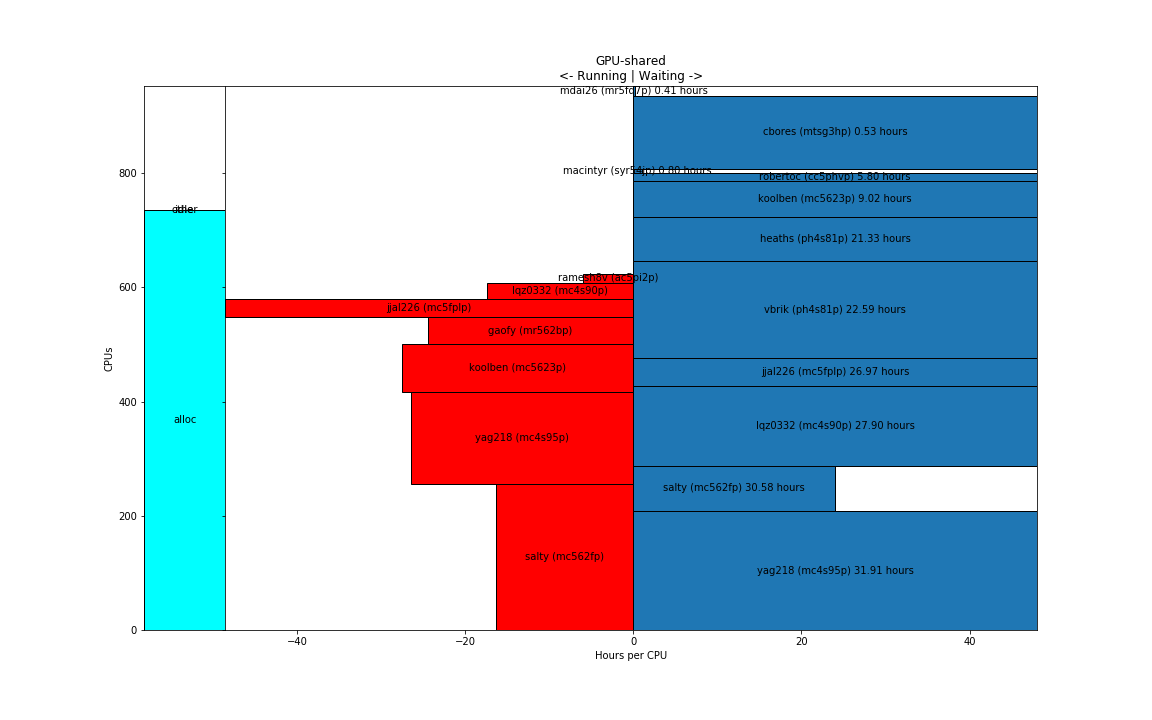

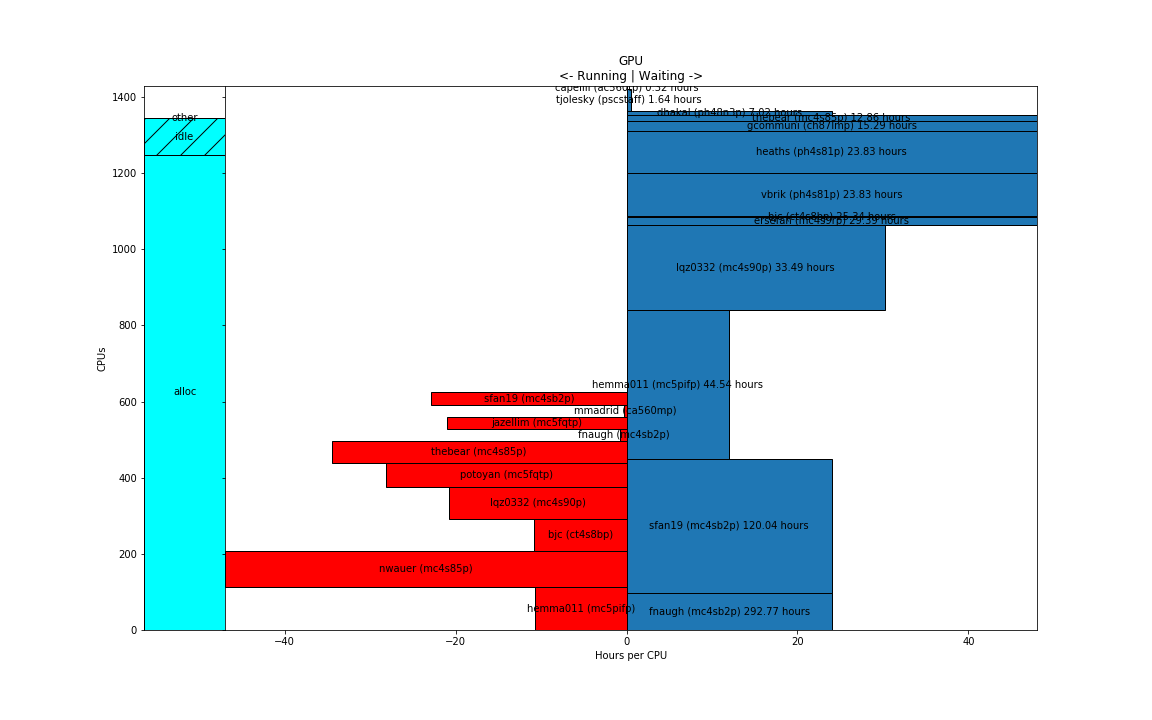

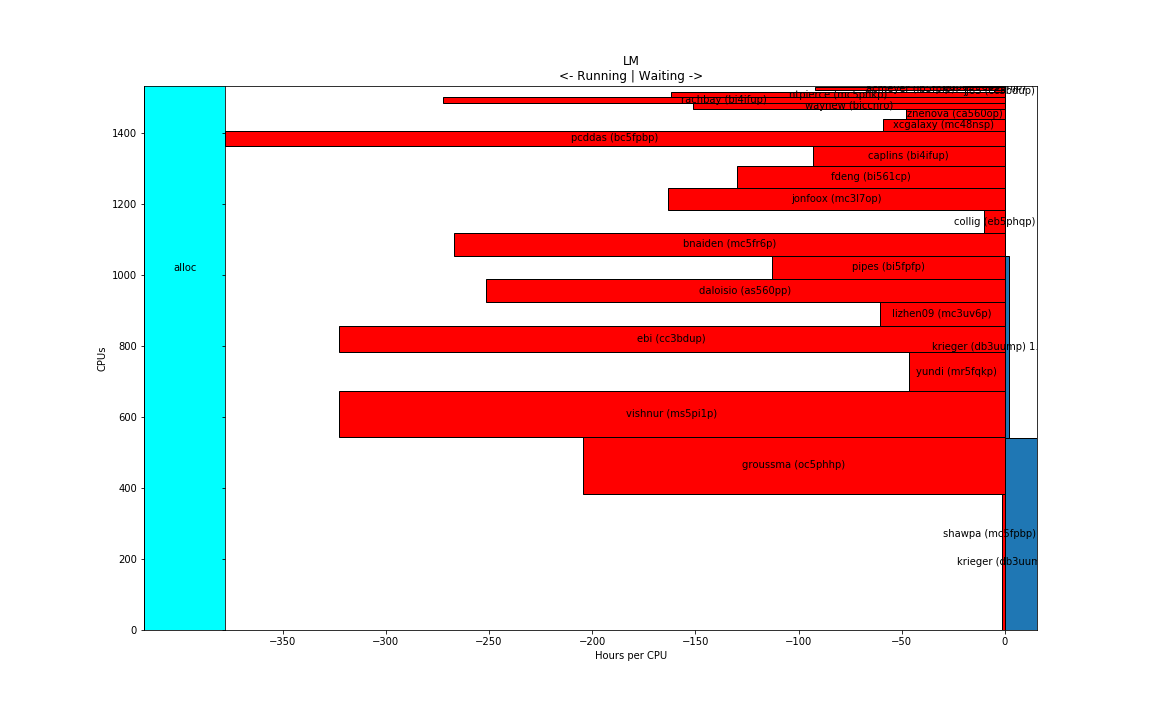

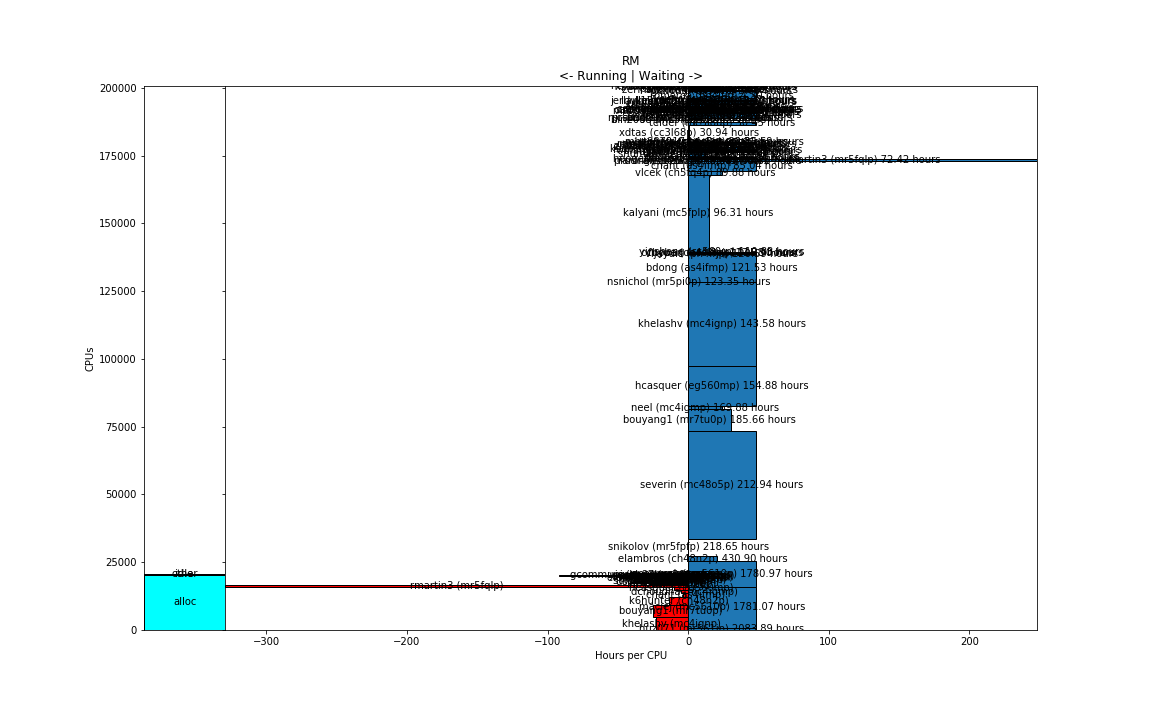

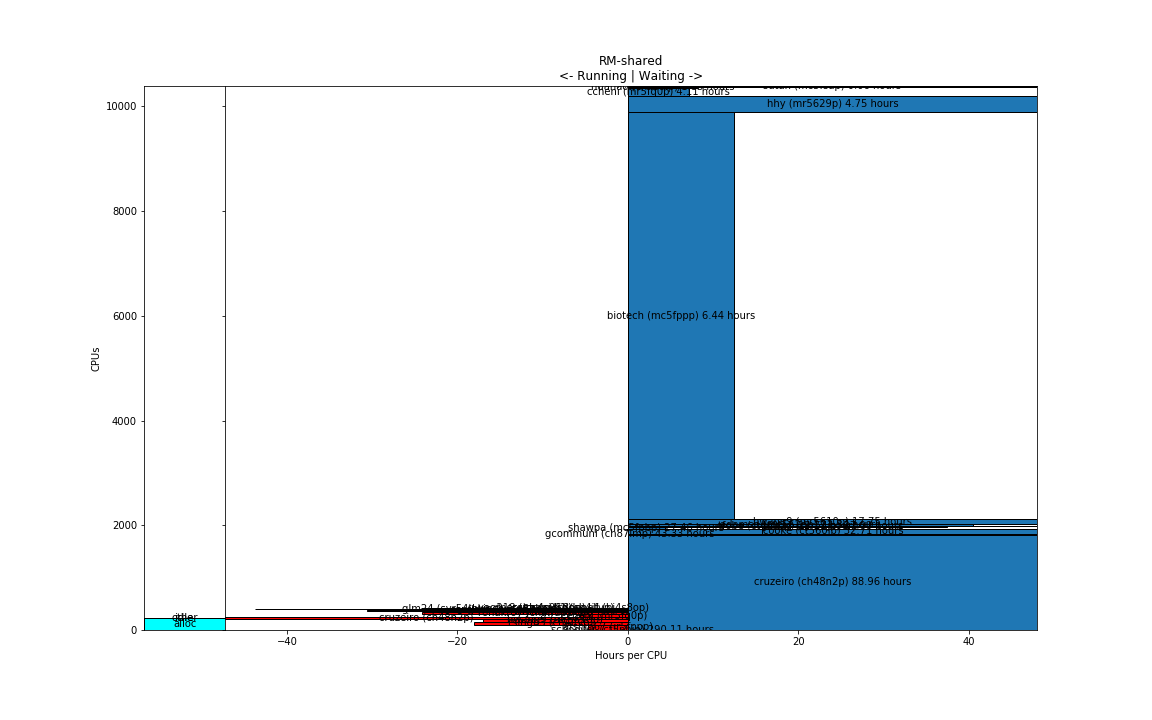

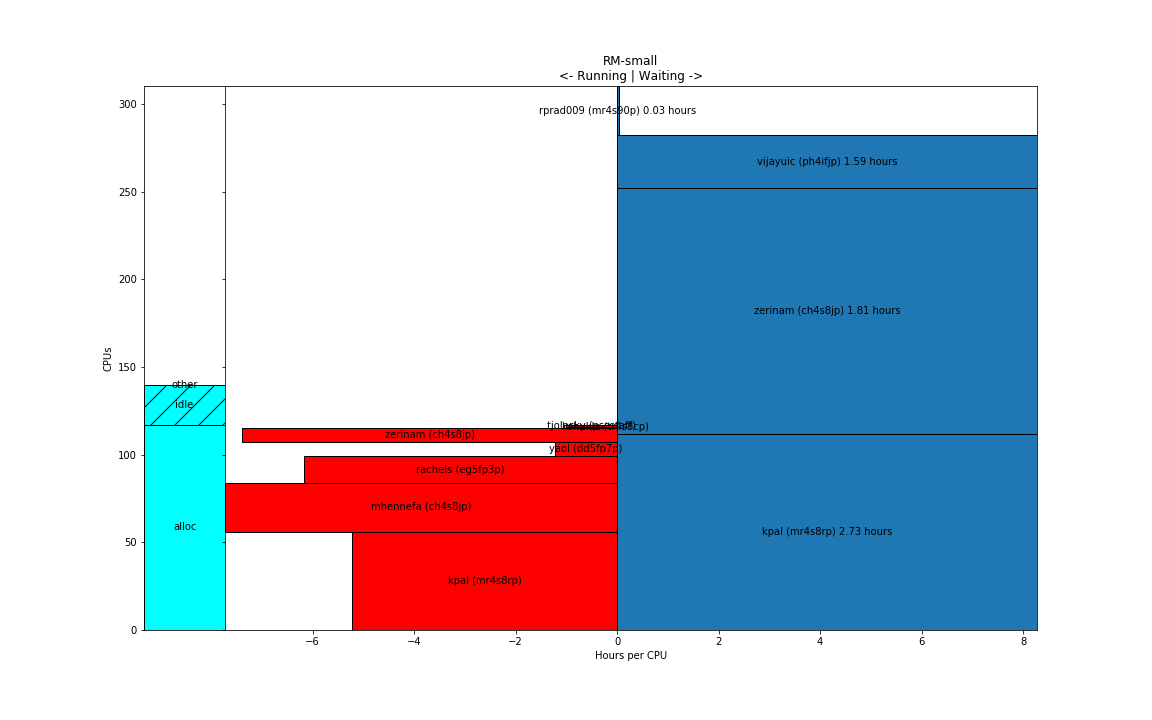

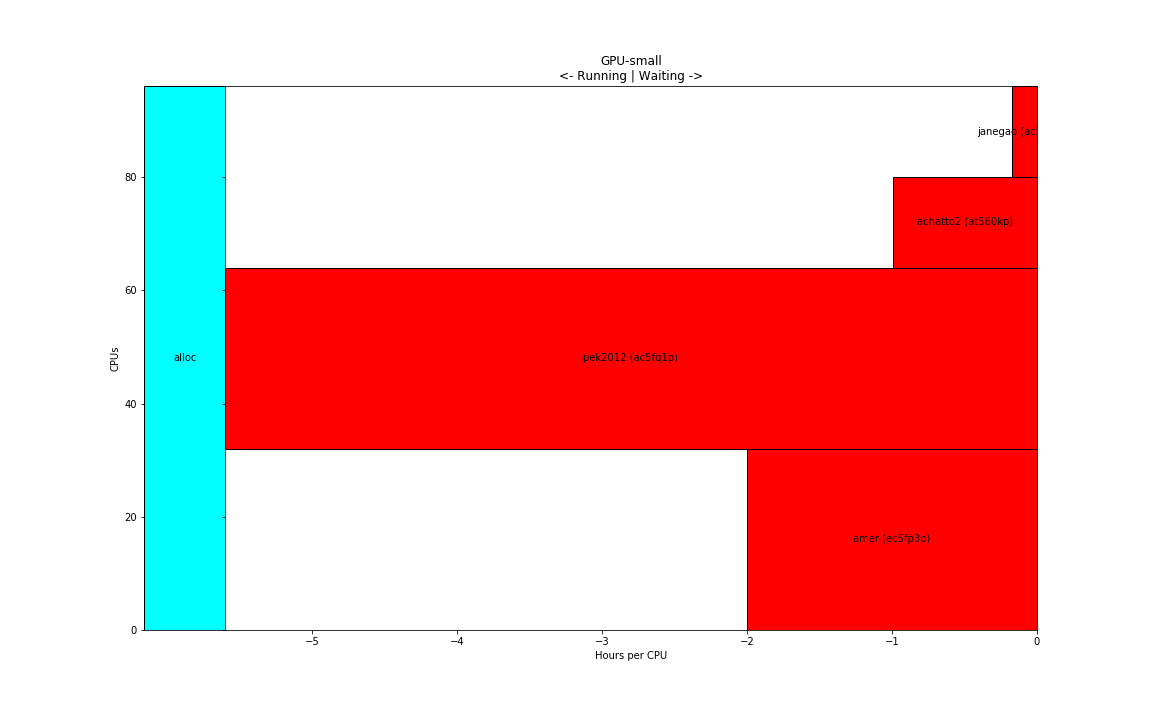

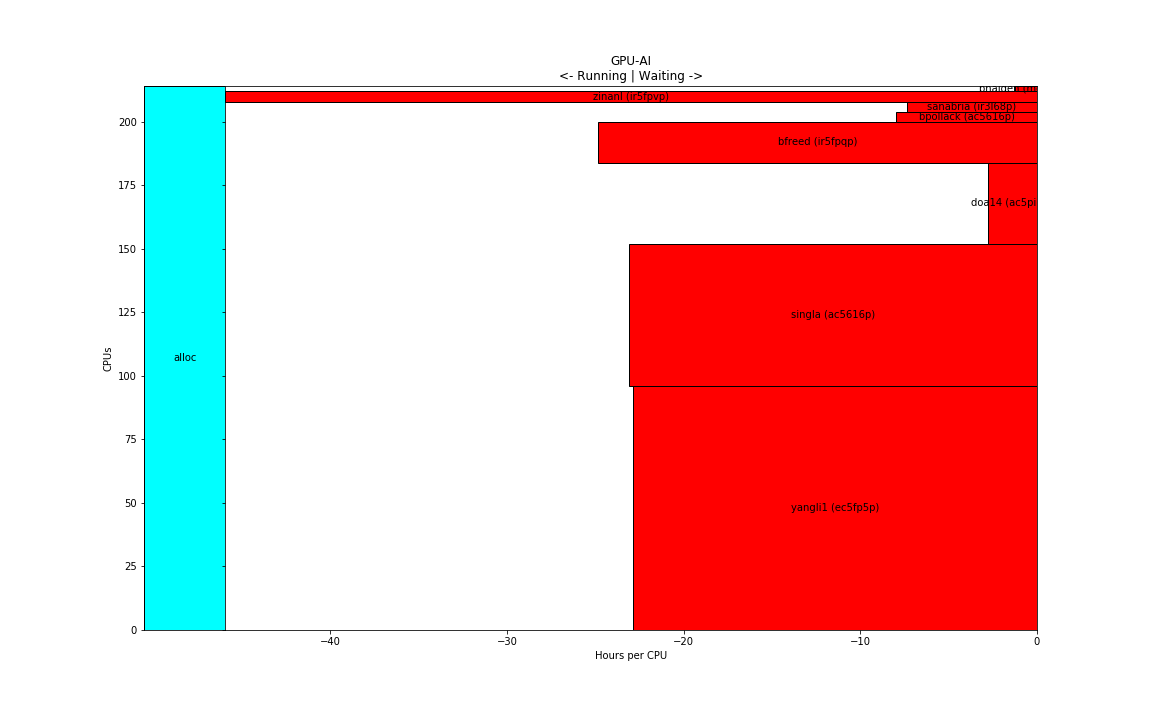

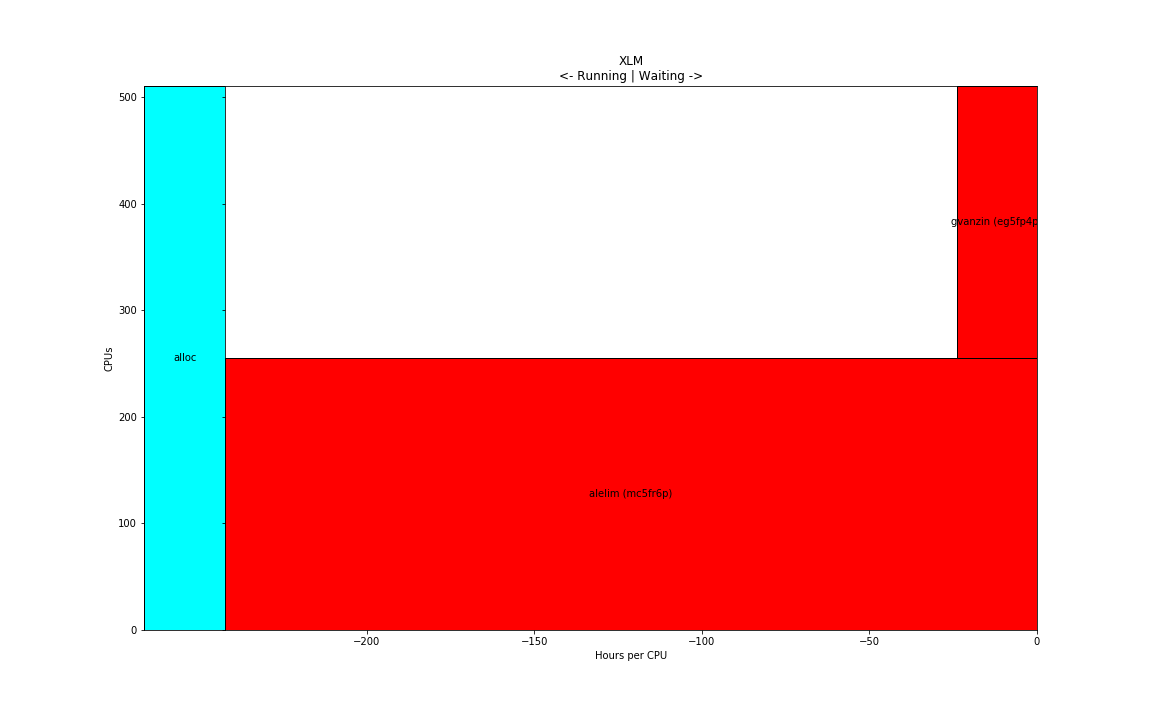

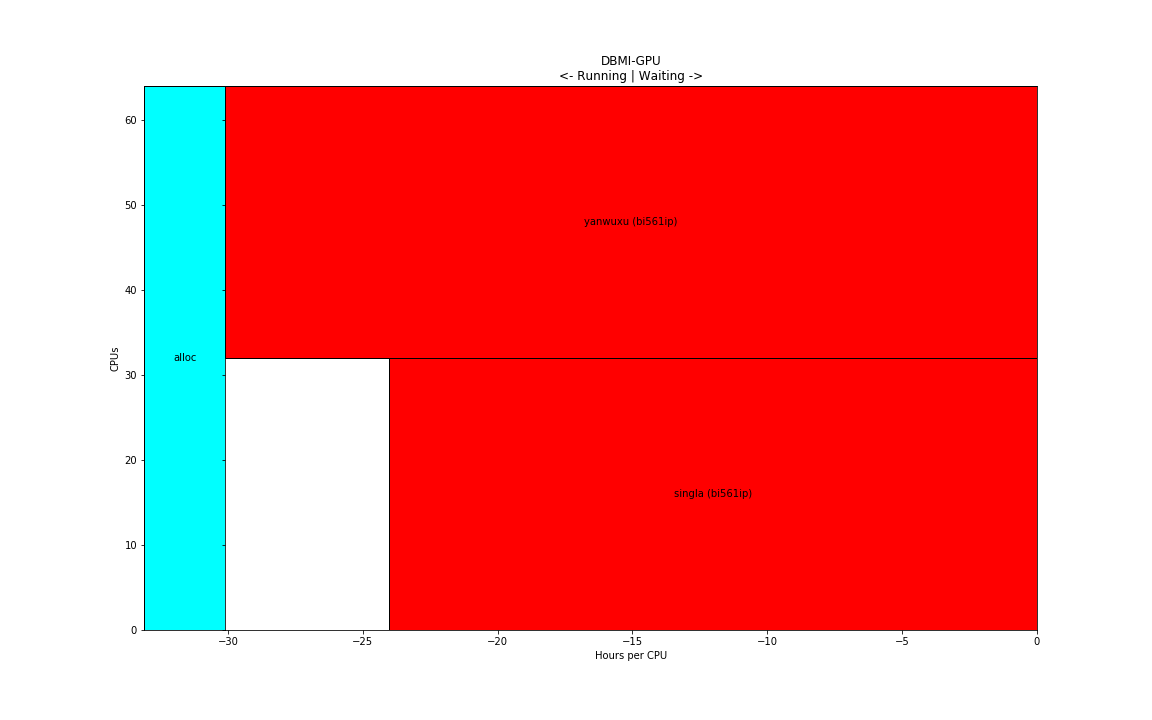

In [379]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%matplotlib inline
#%matplotlib qt
plt.rcParams["figure.figsize"] = [16, 10]

for partition in fullDF.PARTITION.unique():
    fig = plt.figure()
    gs = GridSpec(1, 2, width_ratios=[1, 10])
    gs.update(wspace=0.0)
    axes0 = fig.add_subplot(gs[0])
    axes1 = fig.add_subplot(gs[1], sharey=axes0)
    plt.setp(axes1.get_yticklabels(), visible=False)
    axes0.set_ylabel('CPUs')
    plt.setp(axes0.get_xticklabels(), visible=False)
    axes0.get_xaxis().set_ticks([])
    queue_plot(axes1, runDF, waitDF, partition)
    cpu_plot(axes0, partitionCPUDF, partition)
    plt.show()